In [1]:
import SimpleITK as sitk
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
from mrio import dicom_reader,nifti_reader
from models.roi import create_rois, ROI  # Import create_rois and ROI class
from fitting.relaxation_fitting import RelaxationFittingModel
from process import transform,transform_mask,SignalFilter,merge_masks_select_rois
from fitting.analysis import compute_roi_statistics
from visualization.mapplot import (
    show_slice,
    show_mask,
    show_parameter_map_with_rois,
    show_rois_with_mean,
)

In [ ]:
#mask
#input_mask_file= '/home/gizmoo/Desktop/players_aus/P01/T1rhoMaske_P01_T0l.nii.gz'

#6_t2_de3d
#input_dicom_folder_1 = '/home/gizmoo/Desktop/players_aus/P01/PHockey_01_T0_l/DICOM_translated/MrtC-Studie_Hockey_01_GAPF71806/20210719_1019/6_t2_de3d_we_cor_L_11104'

#7_T2-star_map
#input_dicom_folder_T2_Star = '/home/gizmoo/Desktop/players_aus/P01/PHockey_01_T0_l/DICOM_translated/MrtC-Studie_Hockey_01_GAPF71806/20210719_1019/7_T2-star_map_3D_cor_L_12533'

#14_T2_map
#input_dicom_folder_T2 = '/home/gizmoo/Desktop/players_T1/P15/PHockey_15_T1_r/DICOM_translated/MRTC-Studie_Hockey_15_GAPF76309/20211213_1336/14_T2_map_48slc_27241'

#10_T1rho---
sl1 = '/home/gizmoo/Desktop/players_aus/P01/PHockey_01_T0_l/DICOM_translated/MrtC-Studie_Hockey_01_GAPF71806/20210719_1019/10_T1rho_cor_NATURE_L_16304'
sl2 = '/home/gizmoo/Desktop/players_aus/P01/PHockey_01_T0_l/DICOM_translated/MrtC-Studie_Hockey_01_GAPF71806/20210719_1019/11_T1rho_cor_NATURE_L_16304'
sl3 = '/home/gizmoo/Desktop/players_aus/P01/PHockey_01_T0_l/DICOM_translated/MrtC-Studie_Hockey_01_GAPF71806/20210719_1019/12_T1rho_cor_NATURE_L_16304'
sl4 = '/home/gizmoo/Desktop/players_aus/P01/PHockey_01_T0_l/DICOM_translated/MrtC-Studie_Hockey_01_GAPF71806/20210719_1019/13_T1rho_cor_NATURE_L_16304'


In [3]:
# # Bestimmung T2*
# # Convert the paths to Path objects
# mask = transform_mask(
#         input_dicom_folder_1=Path(input_dicom_folder_1),
#         input_mask_file=Path(input_mask_file),
#         input_dicom_folder_2=Path(input_dicom_folder_T2_Star),
#         save_to_disk= False,       
#     )

# print(f"Mask Size: {mask.GetSize()}")

# labels = np.unique( sitk.GetArrayFromImage(mask))
# labels = labels[1::]

    
# images, echos = dicom_reader.read_multiple_echos_one_folder(input_dicom_folder_T2_Star)
# print("Echo Times:", echos)
# print(f"Image Size: {images[0].GetSize()}")

# rois = create_rois(mask, images[0], labels)
# print(f"Number of ROIs Created: {len(rois)}")
# print('*****************************************************************************************************')
# relaxation = 'T2*'
# # Define fitting modell
# fitting_model = RelaxationFittingModel(time_values= echos[1:],model_type=relaxation)
# # Define a filtering strategy

# filter_strategy = SignalFilter(
#     strategy='intensity',
#     intensity_range=(0,100)
# )
# # no outlier
# filter_outlier = SignalFilter(strategy='outlier')
# filter_max = SignalFilter(strategy= 'max', 
#                           max_percentage = 90 )
# # no filter
# filter_none = SignalFilter(strategy='none')
# # snr filter
# filter_snr = SignalFilter(strategy='snr')

# # Fit T2 curve for each ROI
# for roi in rois:
#     print(f"Fitting {relaxation} curve for Label {roi.label_id}...")
#     roi.fit(images=images[1:],fitting_model= fitting_model,filter_strategy =filter_strategy)
#     roi.evaluate_fit_quality(time_values=echos[1:], model_type=relaxation, threshold=0.90)
#     roi.compute_statistics()
#     roi.compute_entropy()
#     print(f"Label {roi.label_id} - Mean_{relaxation}: {roi.mean:.3f} ms, Std_{relaxation}: {roi.std:.3f} ms")
#     print(f"Label {roi.label_id} - Entropy: {roi.entropy:.3f} bits")

# # roi1 = rois[0]
# # voxels = [0,10,20]
# # for voxel in voxels:
# #     voxel_signal = roi1.signal[voxel, :] 
# #     fitting_model.plot_voxel_fit(ydata=voxel_signal, voxel_index=voxel)

# # for roi in rois:
# #     roi.plot_distribution()


In [4]:
# # Bestimmung T2
# # Convert the paths to Path objects
# mask = transform_mask(
#         input_dicom_folder_1=Path(input_dicom_folder_1),
#         input_mask_file=Path(input_mask_file),
#         input_dicom_folder_2=Path(input_dicom_folder_T2),
#         save_to_disk= False,       
#     )
# print(f"Mask Size: {mask.GetSize()}")

# labels = np.unique( sitk.GetArrayFromImage(mask))
# labels = labels[1::]

    
# images, echos = dicom_reader.read_multiple_echos_one_folder(input_dicom_folder_T2)
# print("Echo Times:", echos)
# print(f"Image Size: {images[0].GetSize()}")


# rois = create_rois(mask, images[0], labels)

# print(f"Number of ROIs Created: {len(rois)}")
# print('*****************************************************************************************************')

# relaxation = 'T2'
# # Define fitting modell
# fitting_model = RelaxationFittingModel(time_values= echos[1:],model_type=relaxation)
# # Define a filtering strategy

# filter_strategy = SignalFilter(
#     strategy='intensity',
#     intensity_range=(5,95)
# )
# # no outlier
# filter_outlier = SignalFilter(strategy='outlier')

# # max_intesity_filter 
# filter_max = SignalFilter(strategy= 'max', 
#                           max_percentage = 50 )
# # no filter
# filter_none = SignalFilter(strategy='none')
# # snr filter
# filter_snr = SignalFilter(strategy='snr')

# # Fit T2 curve for each ROI

# for roi in rois:
#     print(f"Fitting {relaxation} curve for Label {roi.label_id}...")
#     roi.fit(images=images[1:],fitting_model= fitting_model,filter_strategy =filter_strategy)
#     roi.evaluate_fit_quality(time_values=echos[1:], model_type=relaxation, threshold=0.90)
#     roi.compute_statistics()
#     print(f"Label {roi.label_id} - Mean_{relaxation}: {roi.mean:.3f} ms, Std_{relaxation}: {roi.std:.3f} ms")

# roi1 = rois[0]
# voxels = [0,10,20]
# for voxel in voxels:
#     voxel_signal = roi1.signal[voxel, :] 
#     fitting_model.plot_voxel_fit(ydata=voxel_signal, voxel_index=voxel)

# for roi in rois:
#     roi.plot_distribution()
    

In [ ]:
# bestimmun T1-rho
spinlock_series = [sl1,sl2,sl3,sl4]

# mask = transform_mask(
#         input_dicom_folder_1=Path(input_dicom_folder_1),
#         input_mask_file=Path(input_mask_file),
#         input_dicom_folder_2=Path(sl1),
#         save_to_disk= False,       
#     )

mask = nifti_reader.load_segmentation_nii("/home/gizmoo/Desktop/players_aus/P01/T1rhoMaske_P01_T0l.nii.gz")
print(f"Mask Size: {mask.GetSize()}")

labels = np.unique( sitk.GetArrayFromImage(mask))
labels = labels[1::]

   
images,echos = dicom_reader.read_multiple_spin_lock_series(spinlock_series)
echos = [10.0,40.0,70.0,100.0]
print("Echo Times:", echos)
print(f"Image Size: {images[0].GetSize()}")

rois = create_rois(mask, images[0], labels)
print(f"Number of ROIs Created: {len(rois)}")
print('*****************************************************************************************************')


relaxation = 'T1-rho'
# Define fitting modell
fitting_model = RelaxationFittingModel(time_values= echos,model_type=relaxation)
# Define a filtering strategy

filter_strategy = SignalFilter(
    strategy='intensity',
    intensity_range=(0,100)
)
# no outlier
filter_outlier = SignalFilter(strategy='outlier')

# max_intesity_filter 
filter_max = SignalFilter(strategy= 'max', 
                          max_percentage = 50 )
# no filter
filter_none = SignalFilter(strategy='none')
# snr filter
filter_snr = SignalFilter(strategy='snr')


# Fit T2 curve for each ROI
for roi in rois:
    print(f"Fitting {relaxation} curve for Label {roi.label_id}...")
    roi.fit(images=images,fitting_model= fitting_model,filter_strategy =filter_none)
    roi.evaluate_fit_quality(time_values=echos, model_type=relaxation, threshold=0.0)
    roi.compute_statistics()
    print(f"Label {roi.label_id} - Mean_{relaxation}: {roi.mean:.3f} ms, Std_{relaxation} : {roi.std:.3f} ms")

# roi1 = rois[0]
# voxels = [0,10,20]
# for voxel in voxels:
#     voxel_signal = roi1.signal[voxel, :] 
#     fitting_model.plot_voxel_fit(ydata=voxel_signal, voxel_index=voxel)

# for roi in rois:
#     roi.plot_distribution()

Mask Size: (256, 256, 48)
Echo Times: [10.0, 40.0, 70.0, 100.0]
Image Size: (256, 256, 48)
Number of ROIs Created: 4
*****************************************************************************************************
Fitting T1-rho curve for Label 1...
Label 1 - Mean_T1-rho: 64.726 ms, Std_T1-rho : 14.257 ms
Fitting T1-rho curve for Label 2...
Label 2 - Mean_T1-rho: 63.839 ms, Std_T1-rho : 14.547 ms
Fitting T1-rho curve for Label 3...
Label 3 - Mean_T1-rho: 54.734 ms, Std_T1-rho : 12.576 ms
Fitting T1-rho curve for Label 4...
Label 4 - Mean_T1-rho: 67.094 ms, Std_T1-rho : 25.788 ms


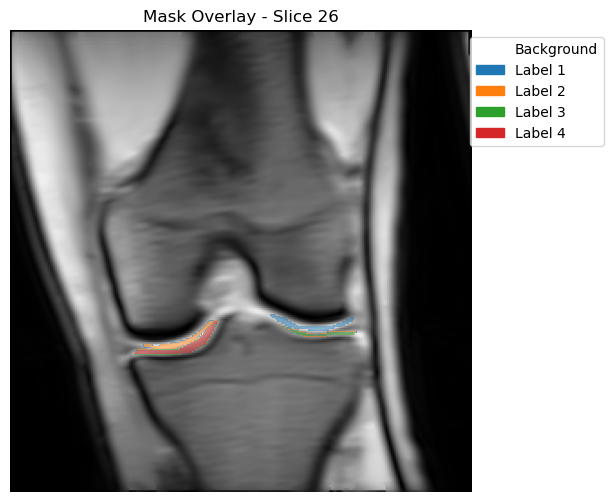

In [6]:
slice_index =26
show_mask(
    image=images[0],
    rois=rois,
    slice_index=slice_index,
    title=f"Mask Overlay - Slice {slice_index}",
    alpha=0.5
)